Machine Learning for Credit Scoring

In [2]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

In [2]:
# Read the data :

# We take the url to download our Dataset : 

Data = pd.read_csv("Loan_data.csv", low_memory = False)
Data.head(2)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,1077501,1296599,5000,5000,4975.0,36 months,10.65,162.87,B,B2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1077430,1314167,2500,2500,2500.0,60 months,15.27,59.83,C,C4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
# We need to check how is our dataset :
Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466285 entries, 0 to 466284
Data columns (total 74 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           466285 non-null  int64  
 1   member_id                    466285 non-null  int64  
 2   loan_amnt                    466285 non-null  int64  
 3   funded_amnt                  466285 non-null  int64  
 4   funded_amnt_inv              466285 non-null  float64
 5   term                         466285 non-null  object 
 6   int_rate                     466285 non-null  float64
 7   installment                  466285 non-null  float64
 8   grade                        466285 non-null  object 
 9   sub_grade                    466285 non-null  object 
 10  emp_title                    438697 non-null  object 
 11  emp_length                   445277 non-null  object 
 12  home_ownership               466285 non-null  object 
 13 

In [4]:
# Checking for missing values :
Data.isnull().sum()

id                       0
member_id                0
loan_amnt                0
funded_amnt              0
funded_amnt_inv          0
                     ...  
all_util            466285
total_rev_hi_lim     70276
inq_fi              466285
total_cu_tl         466285
inq_last_12m        466285
Length: 74, dtype: int64

In [5]:
# Dropping the missing values :

# We tried to erase rows with missing values but it erases every columns.
# Maybe we could decide to remove COLUMNS with missing values instead of rows.
# It is 'less professional' but it is also an easy way to remove features as we have too many of them.

# We decide to remove columns with more than 10% missing values then remove rows which still have missing values.
# It lets us to keep more features.

Data.dropna(axis = 1, thresh = Data.shape[0]*0.9, inplace = True) # axis=1 is to remove comlumns instead of rows
Data.dropna(axis = 0, inplace = True) # axis0 is to remove rows which contain missing values
Data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 437710 entries, 1 to 466283
Data columns (total 49 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   id                          437710 non-null  int64  
 1   member_id                   437710 non-null  int64  
 2   loan_amnt                   437710 non-null  int64  
 3   funded_amnt                 437710 non-null  int64  
 4   funded_amnt_inv             437710 non-null  float64
 5   term                        437710 non-null  object 
 6   int_rate                    437710 non-null  float64
 7   installment                 437710 non-null  float64
 8   grade                       437710 non-null  object 
 9   sub_grade                   437710 non-null  object 
 10  emp_title                   437710 non-null  object 
 11  emp_length                  437710 non-null  object 
 12  home_ownership              437710 non-null  object 
 13  annual_inc    

In [6]:
# Checking for missing values again :
Data.isnull().sum()
Data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 437710 entries, 1 to 466283
Data columns (total 49 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   id                          437710 non-null  int64  
 1   member_id                   437710 non-null  int64  
 2   loan_amnt                   437710 non-null  int64  
 3   funded_amnt                 437710 non-null  int64  
 4   funded_amnt_inv             437710 non-null  float64
 5   term                        437710 non-null  object 
 6   int_rate                    437710 non-null  float64
 7   installment                 437710 non-null  float64
 8   grade                       437710 non-null  object 
 9   sub_grade                   437710 non-null  object 
 10  emp_title                   437710 non-null  object 
 11  emp_length                  437710 non-null  object 
 12  home_ownership              437710 non-null  object 
 13  annual_inc    

In [7]:
# We compute the base rate to check if our dataset is balanced :
Data.grade.value_counts()/Data.shape[0]

# We observe a huge difference between the grades so we will have to change that.

B    0.293774
C    0.268865
D    0.164465
A    0.160718
E    0.076649
F    0.028402
G    0.007126
Name: grade, dtype: float64

In [8]:
Data.grade.value_counts()

# We see that the smaller group has 3119 values. The idea is to delete enough observations in the other groups to have 
# a balanced dataset.

B    128588
C    117685
D     71988
A     70348
E     33550
F     12432
G      3119
Name: grade, dtype: int64

In [9]:
# We remove columns which are not useful for our study :

Data.drop(columns = ['id', 'member_id', 'sub_grade', 'emp_title', 'loan_status', 'pymnt_plan',
                          'zip_code', 'initial_list_status', 'application_type', 'url', 'policy_code'], inplace = True)

In [10]:
# We change the way dates are given in the dataset :

Data['term'] = Data['term'].str.replace(' months','')
Data['term'] = Data['term'].astype(int)

In [11]:
def emp_length_converter(df, column):
    df[column] = df[column].str.replace('\+ years', '')
    df[column] = df[column].str.replace('< 1 year', str(0))
    df[column] = df[column].str.replace(' years', '')
    df[column] = df[column].str.replace(' year', '')
    df[column] = pd.to_numeric(df[column])

In [12]:
# We change the type and the format of emp_length :

emp_length_converter(Data,'emp_length')
Data['emp_length']

1          0
3         10
4          1
5          3
6          8
          ..
466279     4
466280     4
466281    10
466282     7
466283     3
Name: emp_length, Length: 437710, dtype: int64

In [13]:
def date_columns(df, column):
    # store current month
    today_date = pd.to_datetime('2022-04-01')
    # convert to datetime format
    df[column] = pd.to_datetime(df[column], format = "%b-%y")
    # calculate the difference in months and add to a new column
    df['mths_since_' + column] = round(pd.to_numeric((today_date - df[column]) / np.timedelta64(1, 'M')))
    # make any resulting -ve values to be equal to the max date
    df['mths_since_' + column] = df['mths_since_' + column].apply(lambda x: df['mths_since_' + column].max() if x < 0 else x)
    # drop the original date column
    df.drop(columns = [column], inplace = True)

In [14]:
date_columns(Data, 'earliest_cr_line')
date_columns(Data, 'issue_d')
date_columns(Data, 'last_pymnt_d')
date_columns(Data, 'last_credit_pull_d')

In [15]:
# Verification of the modified dates in the dataset :

Data[['mths_since_earliest_cr_line', 'mths_since_issue_d', 'mths_since_last_pymnt_d', 'mths_since_last_credit_pull_d']]

,mths_since_earliest_cr_line,mths_since_issue_d,mths_since_last_pymnt_d,mths_since_last_credit_pull_d
1,276.0,124.0,108.0,103.0
3,314.0,124.0,87.0,87.0
4,315.0,124.0,75.0,75.0
5,209.0,124.0,87.0,79.0
6,201.0,124.0,75.0,75.0
...,...,...,...,...
466279,272.0,99.0,75.0,75.0
466280,228.0,99.0,75.0,75.0
466281,298.0,99.0,88.0,75.0
466282,244.0,99.0,75.0,76.0


In [16]:
# The smaller group has 3119 observations and we want to remove enough rows in other groups to have the same number in each
# group

# We define NbA, NbB, NbC, NbD, NbE, NbF and NbG the numbers of rows in each group for the moment :

NbA = 70348
NbB = 128588
NbC = 117685
NbD = 71988
NbE = 33550
NbF = 12432
NbG = 3119

ListNbRows = [NbA, NbB, NbC, NbD, NbE, NbF]

# We define ListNbRowsToDelete the list of the numbers of rows we need to delete for each group :

ListNbRowsToDelete = []
for i in ListNbRows:
    ListNbRowsToDelete.append(i - NbG)

In [17]:
# We divide our dataset in different groups, one for each grade. Then we could delete the number of rows we want for each group.

groups = Data.groupby(Data.grade)

Data_A = groups.get_group('A')
Data_B = groups.get_group('B')
Data_C = groups.get_group('C')
Data_D = groups.get_group('D')
Data_E = groups.get_group('E')
Data_F = groups.get_group('F')
Data_G = groups.get_group('G')

# To make it easier for after we put them in a list :

listGroup = [Data_A, Data_B, Data_C, Data_D, Data_E, Data_F]

In [18]:
# We randomly remove the overpart of each group :

In [19]:
# Firt we try to remove rows one by one, it is the best way to be random :

#for i in range(6):
#    while  ListNbRowsToDelete[i] > 0:
#        n = random.randrange(0, len(listGroup[i].index))
#        listGroup[i] = listGroup[i].drop([listGroup[i].index[n]])
#        ListNbRowsToDelete[i] = ListNbRowsToDelete[i] - 1
        
# Unfortunately this code is very long to run (approximately 3h)

In [20]:
# We try to remove rows ten by ten to obtain a quicker result and it works, it is around 15 min to run!
# It is almost the same code as before :

for i in range(6):
    while  ListNbRowsToDelete[i] > 0:
        n = random.randrange(0, len(listGroup[i].index)-9)
        listGroup[i] = listGroup[i].drop([listGroup[i].index[n], listGroup[i].index[n+1], listGroup[i].index[n+2],
                                         listGroup[i].index[n+3], listGroup[i].index[n+4], listGroup[i].index[n+5],
                                         listGroup[i].index[n+6], listGroup[i].index[n+7], listGroup[i].index[n+8],
                                         listGroup[i].index[n+9]])
        ListNbRowsToDelete[i] = ListNbRowsToDelete[i] - 10
        
# It took 14 min to run
# Attention it does not change Data_A, Data_B etc. It modifies only the list listGroup!

In [21]:
# Now we can concatenate the new DataFrame : 

DataNew = pd.concat(listGroup + [Data_G])

DataNew.shape

(21810, 38)

In [22]:
# As we delete 10 by 10, we do not delete the exact number of rows for each grade
# It is not important but it is to explain why each grade do not have the same rate
print(ListNbRowsToDelete)

[-1, -1, -4, -1, -9, -7]


In [24]:
DataNew.grade.value_counts()/DataNew.shape[0]

G    0.143008
A    0.142962
B    0.142962
D    0.142962
C    0.142824
F    0.142687
E    0.142595
Name: grade, dtype: float64

In [25]:
# In order to work quicker we save the clean dataframe to csv
# We don't have to run the code to clean before each session, we just need to import the following dataframe :
# DataNew.to_csv("cleanData.csv")

In [67]:
# To continue we just open the dataset we saved before :

DataNew = pd.read_csv("cleanData.csv", low_memory=False)
DataNew.head()

,Unnamed: 0,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,emp_length,home_ownership,...,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,acc_now_delinq,mths_since_earliest_cr_line,mths_since_issue_d,mths_since_last_pymnt_d,mths_since_last_credit_pull_d
0,1158,12000,12000,12000.0,36,7.51,373.33,A,7,RENT,...,0.0,0.0,0.0,390.85,0.0,0.0,283.0,124.0,88.0,88.0
1,1161,25850,25850,25850.0,36,7.90,808.86,A,10,MORTGAGE,...,0.0,0.0,0.0,815.94,0.0,0.0,280.0,124.0,88.0,88.0
2,1165,8000,8000,8000.0,36,7.51,248.89,A,0,RENT,...,0.0,0.0,0.0,264.26,0.0,0.0,210.0,124.0,88.0,78.0
3,1169,4000,4000,4000.0,36,7.90,125.17,A,5,RENT,...,0.0,0.0,0.0,1566.18,0.0,0.0,266.0,124.0,100.0,77.0
4,1171,14000,14000,14000.0,60,8.90,289.94,A,1,RENT,...,0.0,0.0,0.0,289.94,0.0,0.0,273.0,124.0,75.0,75.0


In [68]:
# When we open again the cleaned dataset, we have a new column "Unnamed" with the old indexes.
# We delete it :

DataNew = pd.read_csv("cleanData.csv", low_memory = False)
DataNew.drop(columns = ['Unnamed: 0'], inplace = True)

In [69]:
# We divide our dataset in two parts, one for our target variable and the other one for the other ones :

from sklearn.model_selection import train_test_split
X = DataNew.drop('grade', axis = 1)
y = DataNew['grade']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

In [70]:
# We divide our training data into categorical and numerical subsets :

X_train_cat = X_train.select_dtypes(include = 'object').copy()
X_train_num = X_train.select_dtypes(include = 'number').copy()

In [71]:
# X_train_num
DataNew.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21810 entries, 0 to 21809
Data columns (total 38 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   loan_amnt                      21810 non-null  int64  
 1   funded_amnt                    21810 non-null  int64  
 2   funded_amnt_inv                21810 non-null  float64
 3   term                           21810 non-null  int64  
 4   int_rate                       21810 non-null  float64
 5   installment                    21810 non-null  float64
 6   grade                          21810 non-null  object 
 7   emp_length                     21810 non-null  int64  
 8   home_ownership                 21810 non-null  object 
 9   annual_inc                     21810 non-null  float64
 10  verification_status            21810 non-null  object 
 11  purpose                        21810 non-null  object 
 12  title                          21810 non-null 

In [72]:
# Define an empty dictionary to store chi-squared test results :
chi2_check = {}

In [73]:
from scipy.stats import chi2_contingency
# We loop over each column in the training set to compute chi-statistic with the target variable
for column in X_train_cat:
    chi, p, dof, ex = chi2_contingency(pd.crosstab(y_train, X_train_cat[column]))
    chi2_check.setdefault('Feature',[]).append(column)
    chi2_check.setdefault('p-value',[]).append(round(p, 10))

In [74]:
# convert the dictionary to a DF
chi2_result = pd.DataFrame(data = chi2_check)
chi2_result.sort_values(by = ['p-value'], ascending = True, ignore_index = True, inplace = True)
chi2_result

,Feature,p-value
0,home_ownership,0.0000
1,verification_status,0.0000
2,purpose,0.0000
3,title,0.0000
4,addr_state,0.0827


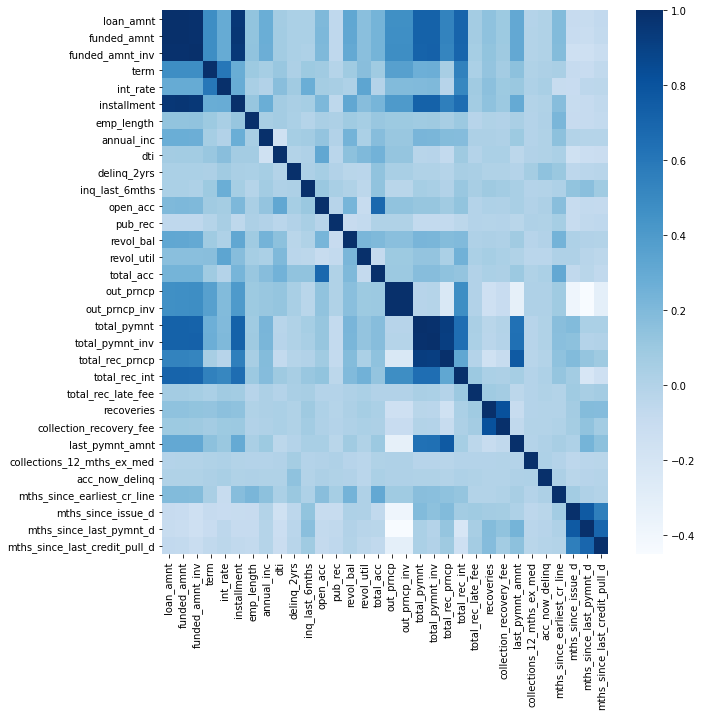

In [75]:
import seaborn as sns
import matplotlib.pyplot as plt
# calculate pair-wise correlations between them
corrmat = X_train_num.corr()
plt.figure(figsize=(10,10))
sns.heatmap(corrmat, cmap="Blues")

In [76]:
# We delete all the features whose correlations are greater than 0.7 in absolute value : 

corrmat[abs(corrmat) > 0.7]
DataNew.drop(columns = ['funded_amnt', 
                        'funded_amnt_inv', 
                        'installment', 
                        'total_pymnt_inv', 
                        'collection_recovery_fee', 
                        'mths_since_last_pymnt_d', 
                        'out_prncp_inv', 
                        'total_rec_prncp'], 
             inplace = True)

In [77]:
# We deleted some columns on DataNew so we need to plit again to have this change in our classifications.

from sklearn.model_selection import train_test_split
X = DataNew.drop('grade', axis = 1)
y = DataNew['grade']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

In [78]:
# Again, we divide our training data into categorical and numerical subsets :

X_train_cat = X_train.select_dtypes(include = 'object').copy()
X_train_num = X_train.select_dtypes(include = 'number').copy()

In [79]:
# We factorize categorical features :

for j in range(len(X_train.columns)):
    if(X_train.dtypes[j] == 'object'):
        X_train[X_train.columns[j]] = pd.factorize(X_train[X_train.columns[j]])[0].tolist()
        X_test[X_test.columns[j]] = pd.factorize(X_test[X_test.columns[j]])[0].tolist()


<ipython-input-79-76d8ec587ec8>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[X_train.columns[j]] = pd.factorize(X_train[X_train.columns[j]])[0].tolist()
<ipython-input-79-76d8ec587ec8>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[X_test.columns[j]] = pd.factorize(X_test[X_test.columns[j]])[0].tolist()


In [80]:
def mean_norm(df_input):
    return df_input.apply(lambda x: (x-x.mean())/ x.std(), axis=0)

In [81]:
# We normalize numerical features :

X_train[X_train_num.columns] = mean_norm(X_train[X_train_num.columns])
X_test[X_train_num.columns] = mean_norm(X_test[X_train_num.columns])

C:\Users\albon\anaconda3\lib\site-packages\pandas\core\frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [82]:
# Now we have a cleaned dataset and we can apply several classification models.
# NB : we have to say 'classification' as we want to predict CATEGORICAL values (label).
# 'Regression' is for numerical values (quantity).
# For each model we will compute the accuracy to find the best one.
# To do that we create a list to store the accuracies
ListAcc = []

Logistic Regression (It is a classification but this tool is called Logistic Regression)

In [83]:
# Logistic Regression

from sklearn.linear_model import LogisticRegression

classifier1 = LogisticRegression()
classifier1.fit(X_train, y_train)

C:\Users\albon\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [84]:
RegPred1 = classifier1.predict(X_test)

In [85]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn import preprocessing

In [86]:
# Results for Logistic Regression :

cf_matrix1 = confusion_matrix(y_test, RegPred1, labels = ["A", "B", "C", "D", "E", "F", "G"]) # Confusion Matrix Calculus
ClassReport1 = classification_report(y_test, RegPred1)
acc1 = accuracy_score(y_test, RegPred1)

ListAcc.append(acc1)

print(cf_matrix1)
print(ClassReport1)
print(acc1)

[[599  13  10   0   1   0   0]
 [473  70  59   1   7   0  14]
 [260  82 141  26  34   0  80]
 [120  78 122  75  52   9 168]
 [ 40  24  89  91  39  36 303]
 [ 19   8  37  58  18  96 386]
 [ 16   4   8  33  16 101 446]]
              precision    recall  f1-score   support

           A       0.39      0.96      0.56       623
           B       0.25      0.11      0.16       624
           C       0.30      0.23      0.26       623
           D       0.26      0.12      0.17       624
           E       0.23      0.06      0.10       622
           F       0.40      0.15      0.22       622
           G       0.32      0.71      0.44       624

    accuracy                           0.34      4362
   macro avg       0.31      0.34      0.27      4362
weighted avg       0.31      0.34      0.27      4362

0.33608436497019717


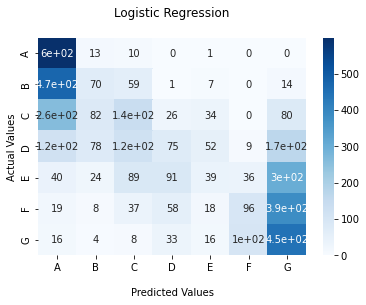

In [87]:
# To plot the confusion matrix :

ax = sns.heatmap(cf_matrix1, annot = True, cmap = "Blues")

ax.set_title('Logistic Regression\n')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values')

ax.xaxis.set_ticklabels(["A", "B", "C", "D", "E", "F", "G"])
ax.yaxis.set_ticklabels(["A", "B", "C", "D", "E", "F", "G"])

plt.show()

KNN Classification

In [88]:
# To do KNN Classification we need to find the best parameters
# We tun hyperparameters with GridSearch (for n_neighbors, p and weights)
# It is a bit long to run (approx 3 min)

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

# Define parameters to test
grid = {'n_neighbors':np.arange(1,7),
        'p':np.arange(1,3),
        'weights':['uniform','distance']
       }

# Define and fit model
knn = KNeighborsClassifier()
knn_cv = GridSearchCV(knn, grid, cv=10)

knn_cv.fit(X_train, y_train)

nb = knn_cv.best_params_['n_neighbors']
p = knn_cv.best_params_['p']
w = knn_cv.best_params_['weights']

# Print results
print("Hyperparameters:", knn_cv.best_params_)
print("Train Score:", round(knn_cv.best_score_, 4))

Hyperparameters: {'n_neighbors': 6, 'p': 1, 'weights': 'distance'}
Train Score: 0.3567


In [89]:
# We do the KNN Classification with the best parameters :

classifier2 = KNeighborsClassifier(n_neighbors=nb, p = p, weights = w)
classifier2.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=6, p=1, weights='distance')

In [90]:
RegPred2 = classifier2.predict(X_test)

In [91]:
# Results for KNN Classification :

cf_matrix2 = confusion_matrix(y_test, RegPred2, labels = ["A", "B", "C", "D", "E", "F", "G"]) # Confusion Matrix Calculus
ClassReport2 = classification_report(y_test, RegPred2)
acc2 = accuracy_score(y_test, RegPred2)

ListAcc.append(acc2)

print(cf_matrix2)
print(ClassReport2)
print(acc2)

[[352 134  47  33  21  34   2]
 [157 214 113  63  41  31   5]
 [ 63 139 214 109  59  31   8]
 [ 47  95 136 151 103  61  31]
 [ 25  53  80 131 162 105  66]
 [ 22  26  51  57 112 196 158]
 [ 17  29  43  52  93 180 210]]
              precision    recall  f1-score   support

           A       0.52      0.57      0.54       623
           B       0.31      0.34      0.33       624
           C       0.31      0.34      0.33       623
           D       0.25      0.24      0.25       624
           E       0.27      0.26      0.27       622
           F       0.31      0.32      0.31       622
           G       0.44      0.34      0.38       624

    accuracy                           0.34      4362
   macro avg       0.34      0.34      0.34      4362
weighted avg       0.34      0.34      0.34      4362

0.3436497019715727


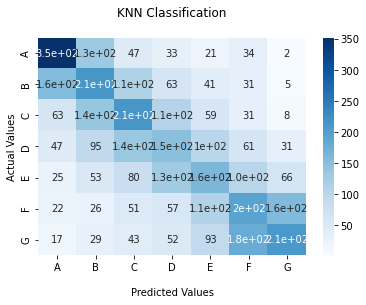

In [92]:
# To plot the confusion matrix :

ax = sns.heatmap(cf_matrix2, annot = True, cmap = "Blues")

ax.set_title('KNN Classification\n')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values')

ax.xaxis.set_ticklabels(["A", "B", "C", "D", "E", "F", "G"])
ax.yaxis.set_ticklabels(["A", "B", "C", "D", "E", "F", "G"])

plt.show()

Decision Tree Classification

In [93]:
# To do Decision Tree Classification we also need to find the best parameter
# We tun hyperparameters with GridSearch (for depth)

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

# Define parameter to test
grid = {'max_depth':np.arange(1,10)}

# Define and fit model

tree = DecisionTreeClassifier()
tree_cv = GridSearchCV(tree, grid, cv=5)

tree_cv.fit(X_train, y_train)

d = tree_cv.best_params_

# Print results
print("Hyperparameters:", tree_cv.best_params_)
print("Train Score:", round(tree_cv.best_score_, 4))

Hyperparameters: {'max_depth': 9}
Train Score: 0.9854


In [94]:
# We do the Decision Tree Classification with the best depth :

classifier3 = DecisionTreeClassifier(max_depth=9, random_state=72) #best parameter we found
classifier3.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=9, random_state=72)

In [95]:
RegPred3 = classifier3.predict(X_test)

In [96]:
# Results for Decision Tree Classification :

cf_matrix3 = confusion_matrix(y_test, RegPred3, labels = ["A", "B", "C", "D", "E", "F", "G"]) # Confusion Matrix Calculus
ClassReport3 = classification_report(y_test, RegPred3)
acc3 = accuracy_score(y_test, RegPred3)

ListAcc.append(acc3)

print(cf_matrix3)
print(ClassReport3)
print(acc3)

[[618   2   0   2   1   0   0]
 [  0 613  11   0   0   0   0]
 [  1  22 598   2   0   0   0]
 [  0   0   7 600  17   0   0]
 [  0   0   0   8 612   2   0]
 [  0   0   0   0   9 608   5]
 [  0   0   0   0   1   4 619]]
              precision    recall  f1-score   support

           A       1.00      0.99      1.00       623
           B       0.96      0.98      0.97       624
           C       0.97      0.96      0.97       623
           D       0.98      0.96      0.97       624
           E       0.96      0.98      0.97       622
           F       0.99      0.98      0.98       622
           G       0.99      0.99      0.99       624

    accuracy                           0.98      4362
   macro avg       0.98      0.98      0.98      4362
weighted avg       0.98      0.98      0.98      4362

0.9784502521779


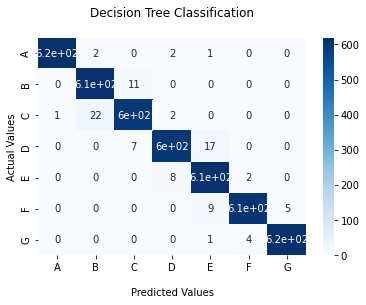

In [97]:
# To plot the confusion matrix :

ax = sns.heatmap(cf_matrix3, annot = True, cmap = "Blues")

ax.set_title('Decision Tree Classification\n')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values')

ax.xaxis.set_ticklabels(["A", "B", "C", "D", "E", "F", "G"])
ax.yaxis.set_ticklabels(["A", "B", "C", "D", "E", "F", "G"])

plt.show()

Random Forest Classification

In [98]:
# We do the Random Forest Classification :

from sklearn.ensemble import RandomForestClassifier

classifier4 = RandomForestClassifier(n_estimators=100)
classifier4.fit(X_train, y_train)

RandomForestClassifier()

In [99]:
RegPred4 = classifier4.predict(X_test)

In [100]:
# Results for Random Forest Classification :

cf_matrix4 = confusion_matrix(y_test, RegPred4, labels = ["A", "B", "C", "D", "E", "F", "G"]) # Confusion Matrix Calculus
ClassReport4 = classification_report(y_test, RegPred4)
acc4 = accuracy_score(y_test, RegPred4)

ListAcc.append(acc4)

print(cf_matrix4)
print(ClassReport4)
print(acc4)

[[616   7   0   0   0   0   0]
 [  5 571  48   0   0   0   0]
 [  1  35 542  44   1   0   0]
 [  0   3  27 540  53   1   0]
 [  0   0   1  40 555  26   0]
 [  0   0   0   4  41 562  15]
 [  0   0   0   2  12  22 588]]
              precision    recall  f1-score   support

           A       0.99      0.99      0.99       623
           B       0.93      0.92      0.92       624
           C       0.88      0.87      0.87       623
           D       0.86      0.87      0.86       624
           E       0.84      0.89      0.86       622
           F       0.92      0.90      0.91       622
           G       0.98      0.94      0.96       624

    accuracy                           0.91      4362
   macro avg       0.91      0.91      0.91      4362
weighted avg       0.91      0.91      0.91      4362

0.9110499770747363


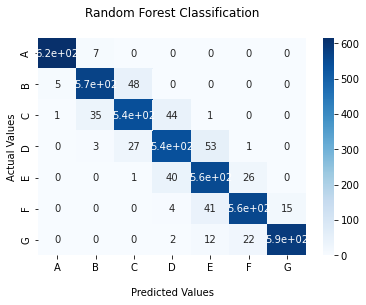

In [101]:
# To plot the confusion matrix :

ax = sns.heatmap(cf_matrix4, annot = True, cmap = "Blues")

ax.set_title('Random Forest Classification\n')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values')

ax.xaxis.set_ticklabels(["A", "B", "C", "D", "E", "F", "G"])
ax.yaxis.set_ticklabels(["A", "B", "C", "D", "E", "F", "G"])

plt.show()

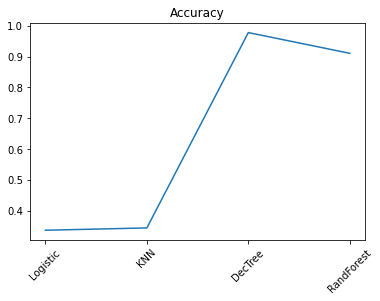

In [102]:
# Let's compare our previous results

# We plot the list of accuracies and we put a name for each point :
labels = ['Logistic', 'KNN', 'DecTree', 'RandForest']

x = [i for i in range(1,5)]
plt.title('Accuracy')
plt.plot(x, ListAcc)
plt.xticks(x, labels, rotation = 45)

plt.show()

We can observe that Decision Tree and Random Forest are way more efficient. Logistic and KNN are almost equal.

First, Decision Tree has a very high accuracy. It must be overfitted on the data. Random Forest lets us to do not overfit the data and its accuracy is lower. It is normal but the accuracy for Random Forest reminds too high.

It is possible that we have a perfectly correlated variable and we should remove it otherwise it would be cheating.

After taking a look at our variables, it appears that the interest rates could be this too correlated variable. Indeed it is calculated according to the grades. In the next part we are going to do the classications again without the interest rate.

In [104]:
# We delete int_rate to try new classifications :

DataNew.drop(columns = ['int_rate'], 
             inplace = True)

In [105]:
# We deleted some columns on DataNew so we need to plit again to have this change in our classifications.

from sklearn.model_selection import train_test_split
X = DataNew.drop('grade', axis = 1)
y = DataNew['grade']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

In [106]:
# Again, we divide our training data into categorical and numerical subsets :

X_train_cat = X_train.select_dtypes(include = 'object').copy()
X_train_num = X_train.select_dtypes(include = 'number').copy()

In [107]:
# We factorize categorical features again too:

for j in range(len(X_train.columns)):
    if(X_train.dtypes[j] == 'object'):
        X_train[X_train.columns[j]] = pd.factorize(X_train[X_train.columns[j]])[0].tolist()
        X_test[X_test.columns[j]] = pd.factorize(X_test[X_test.columns[j]])[0].tolist()

<ipython-input-107-9e9329ef1f72>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[X_train.columns[j]] = pd.factorize(X_train[X_train.columns[j]])[0].tolist()
<ipython-input-107-9e9329ef1f72>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[X_test.columns[j]] = pd.factorize(X_test[X_test.columns[j]])[0].tolist()


In [108]:
def mean_norm(df_input):
    return df_input.apply(lambda x: (x-x.mean())/ x.std(), axis=0)

In [109]:
# We normalize numerical features :

X_train[X_train_num.columns] = mean_norm(X_train[X_train_num.columns])
X_test[X_train_num.columns] = mean_norm(X_test[X_train_num.columns])

C:\Users\albon\anaconda3\lib\site-packages\pandas\core\frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [138]:
# The new classifations are ready
# For each model we will compute the accuracy to find the best one.
# To do that we create a list to store the accuracies
ListAcc2 = []

Logistic Regression

In [111]:
# Logistic Regression

from sklearn.linear_model import LogisticRegression

classifier1 = LogisticRegression()
classifier1.fit(X_train, y_train)

C:\Users\albon\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [112]:
RegPred1 = classifier1.predict(X_test)

In [120]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn import preprocessing

In [139]:
# Results for Logistic Regression :

cf_matrix1 = confusion_matrix(y_test, RegPred1, labels = ["A", "B", "C", "D", "E", "F", "G"]) # Confusion Matrix Calculus
ClassReport1 = classification_report(y_test, RegPred1)
acc1 = accuracy_score(y_test, RegPred1)

ListAcc2.append(acc1)

print(cf_matrix1)
print(ClassReport1)
print(acc1)

[[563  16  14  16   2   0  12]
 [390  71  55  51   8   3  46]
 [241  73  57  79  17  23 133]
 [153  70  56  99  13  32 201]
 [ 76  43  62  72  14  59 296]
 [ 59  28  33  52   5  80 365]
 [ 42   3  23  49   3  68 436]]
              precision    recall  f1-score   support

           A       0.37      0.90      0.52       623
           B       0.23      0.11      0.15       624
           C       0.19      0.09      0.12       623
           D       0.24      0.16      0.19       624
           E       0.23      0.02      0.04       622
           F       0.30      0.13      0.18       622
           G       0.29      0.70      0.41       624

    accuracy                           0.30      4362
   macro avg       0.26      0.30      0.23      4362
weighted avg       0.26      0.30      0.23      4362

0.30261348005502064


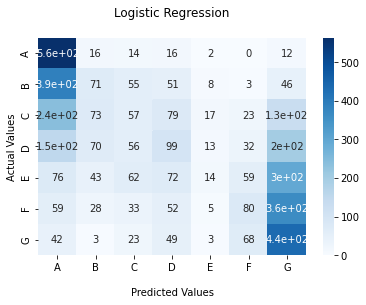

In [114]:
# To plot the confusion matrix :

ax = sns.heatmap(cf_matrix1, annot = True, cmap = "Blues")

ax.set_title('Logistic Regression\n')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values')

ax.xaxis.set_ticklabels(["A", "B", "C", "D", "E", "F", "G"])
ax.yaxis.set_ticklabels(["A", "B", "C", "D", "E", "F", "G"])

plt.show()

KNN Classication

In [115]:
# To do KNN Classification we need to find the best parameters
# We tun hyperparameters with GridSearch (for n_neighbors, p and weights)
# It is a bit long to run (approx 3 min)

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

# Define parameters to test
grid = {'n_neighbors':np.arange(1,7),
        'p':np.arange(1,3),
        'weights':['uniform','distance']
       }

# Define and fit model
knn = KNeighborsClassifier()
knn_cv = GridSearchCV(knn, grid, cv=10)

knn_cv.fit(X_train, y_train)

nb = knn_cv.best_params_['n_neighbors']
p = knn_cv.best_params_['p']
w = knn_cv.best_params_['weights']

# Print results
print("Hyperparameters:", knn_cv.best_params_)
print("Train Score:", round(knn_cv.best_score_, 4))

Hyperparameters: {'n_neighbors': 6, 'p': 1, 'weights': 'distance'}
Train Score: 0.2603


In [116]:
# We do the KNN Classification with the best parameters :

classifier2 = KNeighborsClassifier(n_neighbors=nb, p = p, weights = w)
classifier2.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=6, p=1, weights='distance')

In [117]:
RegPred2 = classifier2.predict(X_test)

In [140]:
# Results for KNN Classification :

cf_matrix2 = confusion_matrix(y_test, RegPred2, labels = ["A", "B", "C", "D", "E", "F", "G"]) # Confusion Matrix Calculus
ClassReport2 = classification_report(y_test, RegPred2)
acc2 = accuracy_score(y_test, RegPred2)

ListAcc2.append(acc2)

print(cf_matrix2)
print(ClassReport2)
print(acc2)

[[266 134  46  45  49  77   6]
 [161 172  82  65  61  64  19]
 [111 127 140  83  73  60  29]
 [ 82 105 114  97  83  86  57]
 [ 57  72  98  96 117  94  88]
 [ 43  46  79  86 110 130 128]
 [ 40  45  71  72 111 135 150]]
              precision    recall  f1-score   support

           A       0.35      0.43      0.38       623
           B       0.25      0.28      0.26       624
           C       0.22      0.22      0.22       623
           D       0.18      0.16      0.17       624
           E       0.19      0.19      0.19       622
           F       0.20      0.21      0.21       622
           G       0.31      0.24      0.27       624

    accuracy                           0.25      4362
   macro avg       0.24      0.25      0.24      4362
weighted avg       0.24      0.25      0.24      4362

0.2457588262265016


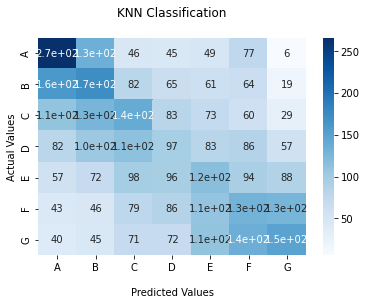

In [119]:
# To plot the confusion matrix :

ax = sns.heatmap(cf_matrix2, annot = True, cmap = "Blues")

ax.set_title('KNN Classification\n')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values')

ax.xaxis.set_ticklabels(["A", "B", "C", "D", "E", "F", "G"])
ax.yaxis.set_ticklabels(["A", "B", "C", "D", "E", "F", "G"])

plt.show()

Decision Tree Classification

In [121]:
# To do Decision Tree Classification we also need to find the best parameter
# We tun hyperparameters with GridSearch (for depth)

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

# Define parameter to test
grid = {'max_depth':np.arange(1,10)}

# Define and fit model

tree = DecisionTreeClassifier()
tree_cv = GridSearchCV(tree, grid, cv=5)

tree_cv.fit(X_train, y_train)

d = tree_cv.best_params_

# Print results
print("Hyperparameters:", tree_cv.best_params_)
print("Train Score:", round(tree_cv.best_score_, 4))

Hyperparameters: {'max_depth': 9}
Train Score: 0.408


In [122]:
# We do the Decision Tree Classification with the best depth :

classifier3 = DecisionTreeClassifier(max_depth=9, random_state=72) #best parameter we found
classifier3.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=9, random_state=72)

In [125]:
RegPred3 = classifier3.predict(X_test)

In [141]:
# Results for Decision Tree Classification :

cf_matrix3 = confusion_matrix(y_test, RegPred3, labels = ["A", "B", "C", "D", "E", "F", "G"]) # Confusion Matrix Calculus
ClassReport3 = classification_report(y_test, RegPred3)
acc3 = accuracy_score(y_test, RegPred3)

ListAcc2.append(acc3)

print(cf_matrix3)
print(ClassReport3)
print(acc3)

[[394 144  42  23  17   2   1]
 [123 263 127  80  18   9   4]
 [ 49 143 201 129  43  32  26]
 [ 23  63 140 186 111  52  49]
 [  6  34  83 100 184  95 120]
 [  6  10  31  27 166 160 222]
 [  5  10  27  20 111 131 320]]
              precision    recall  f1-score   support

           A       0.65      0.63      0.64       623
           B       0.39      0.42      0.41       624
           C       0.31      0.32      0.32       623
           D       0.33      0.30      0.31       624
           E       0.28      0.30      0.29       622
           F       0.33      0.26      0.29       622
           G       0.43      0.51      0.47       624

    accuracy                           0.39      4362
   macro avg       0.39      0.39      0.39      4362
weighted avg       0.39      0.39      0.39      4362

0.39156350298028425


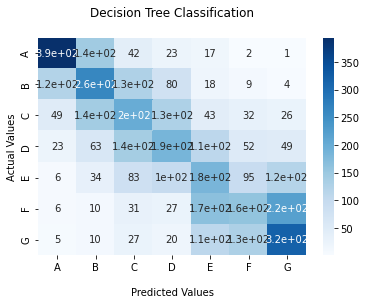

In [127]:
# To plot the confusion matrix :

ax = sns.heatmap(cf_matrix3, annot = True, cmap = "Blues")

ax.set_title('Decision Tree Classification\n')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values')

ax.xaxis.set_ticklabels(["A", "B", "C", "D", "E", "F", "G"])
ax.yaxis.set_ticklabels(["A", "B", "C", "D", "E", "F", "G"])

plt.show()

Random Forest Classification

In [128]:
# We do the Random Forest Classification :

from sklearn.ensemble import RandomForestClassifier

classifier4 = RandomForestClassifier(n_estimators=100)
classifier4.fit(X_train, y_train)

RandomForestClassifier()

In [129]:
RegPred4 = classifier4.predict(X_test)

In [142]:
# Results for Random Forest Classification :

cf_matrix4 = confusion_matrix(y_test, RegPred4, labels = ["A", "B", "C", "D", "E", "F", "G"]) # Confusion Matrix Calculus
ClassReport4 = classification_report(y_test, RegPred4)
acc4 = accuracy_score(y_test, RegPred4)

ListAcc2.append(acc4)

print(cf_matrix4)
print(ClassReport4)
print(acc4)

[[516  89  13   2   2   1   0]
 [136 344  95  26   9   9   5]
 [ 53 141 243 110  32  20  24]
 [ 19  55 132 218  97  50  53]
 [  4  21  69 109 182 103 134]
 [  5   5  24  41 105 190 252]
 [  4   5  12  21  59 139 384]]
              precision    recall  f1-score   support

           A       0.70      0.83      0.76       623
           B       0.52      0.55      0.54       624
           C       0.41      0.39      0.40       623
           D       0.41      0.35      0.38       624
           E       0.37      0.29      0.33       622
           F       0.37      0.31      0.34       622
           G       0.45      0.62      0.52       624

    accuracy                           0.48      4362
   macro avg       0.46      0.48      0.47      4362
weighted avg       0.46      0.48      0.47      4362

0.47615772581384685


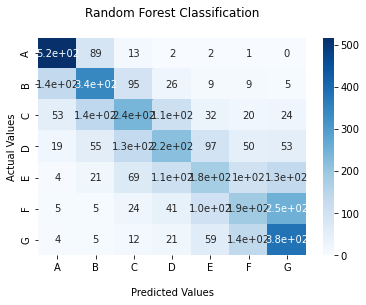

In [131]:
# To plot the confusion matrix :

ax = sns.heatmap(cf_matrix4, annot = True, cmap = "Blues")

ax.set_title('Random Forest Classification\n')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values')

ax.xaxis.set_ticklabels(["A", "B", "C", "D", "E", "F", "G"])
ax.yaxis.set_ticklabels(["A", "B", "C", "D", "E", "F", "G"])

plt.show()

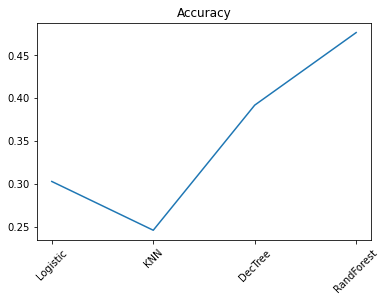

In [143]:
# Let's compare our previous results

# We plot the list of accuracies and we put a name for each point :
labels = ['Logistic', 'KNN', 'DecTree', 'RandForest']

x = [i for i in range(1,5)]
plt.title('Accuracy')
plt.plot(x, ListAcc2)
plt.xticks(x, labels, rotation = 45)

plt.show()

To conclude, our best accuracy is around 48% which is more realistic as we have 7 different outcomes. KNN appears to be the worst model, it can be because of its parameters. 
Logistic Regression is quite good as it is a really basic model.
Decision Tree is good, the accuracy is under Random Forest's one, so it does not seem to be overfitted as it was before. Maybe the depth could be even bigger to fit more the data.
Random Forest is a powerful model (no overfitting in general) and the accuracy is really good. Our target was to do more than 14% (better than random) and it did 48%.